In [68]:
# All imports


from prettyprinter import pprint 

import numpy as np
import pandas as pd
import json


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import seaborn as sns
sns.set_style('dark')

import tensorly as tl
from tensorly.decomposition import parafac,tucker

import scipy,sklearn
import  sklearn.decomposition

import time

In [69]:
# import data
# Unzip if not already done
import os,shutil
if not 'mumbai-hexclusters-2019-4-All-HourlyAggregate.csv' in os.listdir('../data/'):
    shutil.unpack_archive(filename="../mumbai-hexclusters-2019-4-All-HourlyAggregate.zip",extract_dir='../data/')

In [70]:
df = pd.read_csv('../data/mumbai-hexclusters-2019-4-All-HourlyAggregate.csv')

In [71]:
df.head()

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,171,206,15,2949.31,1139.79,2772.51,1.40
1,255,439,10,5045.33,839.06,4978.27,1.18
2,110,18,0,2932.71,537.47,2886.25,1.19
3,38,7,5,2690.29,741.75,2591.41,1.31
4,277,219,10,4848.73,730.67,4796.48,1.16


In [72]:
origins = sorted(df.sourceid.unique())
destinations = sorted(df.dstid.unique())
hods = sorted(df.hod.unique())

origin_max = max(origins)
dest_max = max(destinations)
hod_max = max(hods)

list(map(min,[origins,destinations,hods]))

# Make numpy tensor
nptensor = np.zeros(     (   dest_max, origin_max, hod_max+1  )      ) 
        
def transfer(x):
    nptensor[x.dstid-1 ,x.sourceid-1, x.hod] = x.mean_travel_time
    return 0

df.pipe(transfer)

0

In [73]:
print(nptensor[300,3,10])
# verify if nptensor has right data
df[df.sourceid==4] [ df.dstid==301 ] [ df.hod==10]

1718.02


<ipython-input-73-82e206264241>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.sourceid==4] [ df.dstid==301 ] [ df.hod==10]
<ipython-input-73-82e206264241>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.sourceid==4] [ df.dstid==301 ] [ df.hod==10]


,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
1261503,4,301,10,1718.02,619.9,1633.91,1.35


In [74]:
# create tensorly data
#nptensor -= nptensor.mean()
tensor = tl.tensor(nptensor)

In [75]:
# parafac with ortogonality
def tensorrank2variance(k, algo):
    _verbose=0
    _iters = 100
    now = time.time()
    if algo=='parafac':
        _factors,_errors = parafac(tensor, rank=k, return_errors=True, orthogonalise=False, n_iter_max = _iters, verbose=_verbose,linesearch=True)
        _weights, _components = _factors
        _params = sum(tensor.shape)*k
        reconstruction_error = tl.norm(tensor - tl.cp_to_tensor((_weights, _components)))
       
        #print(_weights)
    
    elif algo=='parafacortho':
        _factors,_errors = parafac(tensor, rank=k, return_errors=True, orthogonalise=True, n_iter_max=_iters, verbose=_verbose)
        _weights, _components = _factors
        _params = sum(tensor.shape)*k
        reconstruction_error = tl.norm(tensor - tl.cp_to_tensor((_weights, _components)))
        #print(_weights)
        
        
        
    elif algo=='tucker':
        _core, _factors, =  tucker(tensor, rank=k, verbose = 1)
        _params = sum(tensor.shape)*k + k**3
        reconstruction_error = tl.norm(  tensor - tl.tucker_to_tensor((_core, _factors))  )
        

    
    #print(reconstruction_error / tl.norm(tensor))
    #print(errors)

    # total_var = norm**2 = explained_var + error**2
    # => total_var = explained_var + error**2
    # => explained_var = total_var - error**2
    # => explained_var_normalized = explained_var / total_var

    total_variance = tl.norm(tensor)**2
    explained_variance = total_variance - reconstruction_error**2
    explained_variance_normalized = explained_variance / total_variance
    
    print()
    print(f'error -> {reconstruction_error}')
    print(f'{algo} - rank-{k} explained->',explained_variance_normalized)
    took = time.time() - now
    print(f'{algo} - rank-{k} took->',took)
    print()
    return explained_variance_normalized,took,_params


In [9]:
explained_parafac = [tensorrank2variance(k, 'parafac') for k in range(1,21)]


error -> 4761583.105480775
parafac - rank-1 explained-> 0.6642287371449556
parafac - rank-1 took-> 0.9733319282531738


error -> 4356951.96293708
parafac - rank-2 explained-> 0.7188705582169544
parafac - rank-2 took-> 23.698727130889893


error -> 4045296.74390623
parafac - rank-3 explained-> 0.7576508188404654
parafac - rank-3 took-> 30.711926460266113


error -> 3845668.3072755258
parafac - rank-4 explained-> 0.7809796678586471
parafac - rank-4 took-> 35.83296203613281


error -> 3655403.602357974
parafac - rank-5 explained-> 0.8021156458299987
parafac - rank-5 took-> 42.74951767921448


error -> 3545822.2588669746
parafac - rank-6 explained-> 0.8138021290546553
parafac - rank-6 took-> 47.99699115753174


error -> 3468230.7544577704
parafac - rank-7 explained-> 0.8218619241953847
parafac - rank-7 took-> 55.55217099189758


error -> 3398276.284376246
parafac - rank-8 explained-> 0.8289755681995039
parafac - rank-8 took-> 61.473450660705566


error -> 3327274.6489717932
parafac - rank

In [12]:
explained_parafacortho = [tensorrank2variance(k, 'parafacortho') for k in range(1,21)]


error -> 4761583.105480774
parafacortho - rank-1 explained-> 0.6642287371449557
parafacortho - rank-1 took-> 1.9574329853057861


error -> 4359413.4189517535
parafacortho - rank-2 explained-> 0.7185528208490924
parafacortho - rank-2 took-> 14.803601264953613


error -> 4046679.7941766637
parafacortho - rank-3 explained-> 0.7574850765380068
parafacortho - rank-3 took-> 19.78469491004944


error -> 3848279.4769198876
parafacortho - rank-4 explained-> 0.7806821417310889
parafacortho - rank-4 took-> 26.00175905227661


error -> 3658158.278112254
parafacortho - rank-5 explained-> 0.8018172860943336
parafacortho - rank-5 took-> 32.47164177894592


error -> 3547598.415492124
parafacortho - rank-6 explained-> 0.8136155436093532
parafacortho - rank-6 took-> 38.976557970047


error -> 3466504.3862326057
parafacortho - rank-7 explained-> 0.8220392223027047
parafacortho - rank-7 took-> 43.246601581573486


error -> 3398020.7769391416
parafacortho - rank-8 explained-> 0.8290012849852069
parafacort

In [11]:
explained_tucker = [tensorrank2variance(k, 'tucker') for k in range(1,21)]

c:\users\bzsnk3\miniconda3\lib\site-packages\tensorly\tucker_tensor.py:357: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


reconstruction error=0.5794577318570727, variation=1.824714990217302e-08.
converged in 2 iterations.

error -> 4761583.106572001
tucker - rank-1 explained-> 0.6642287369910561
tucker - rank-1 took-> 1.7674956321716309

reconstruction error=0.5299334326387715, variation=1.5287991869672446e-05.
converged in 2 iterations.

error -> 4354626.64787237
tucker - rank-2 explained-> 0.7191705569716869
tucker - rank-2 took-> 1.4566750526428223

reconstruction error=0.48982989711076963, variation=2.4548232185339636e-06.
converged in 2 iterations.

error -> 4025083.513342157
tucker - rank-3 explained-> 0.760066671896452
tucker - rank-3 took-> 1.3318264484405518

reconstruction error=0.4662281740676635, variation=5.07846324246386e-05.
converged in 2 iterations.

error -> 3831140.8673999305
tucker - rank-4 explained-> 0.7826312897055311
tucker - rank-4 took-> 1.312140703201294

reconstruction error=0.44166983759294526, variation=8.794273510526196e-07.
converged in 2 iterations.

error -> 3629337.4335

In [13]:
# Lets now build the matrix with shape  (nodes ^ 2) x  t 
print(nptensor.shape)
npmatrix =  np.zeros((nptensor.shape[0] * nptensor.shape[1],nptensor.shape[2]))
print(npmatrix.shape)

for x in range(npmatrix.shape[1]):
    npmatrix[:,x] = nptensor[:,:,x].flatten()
    
    

### SVD for this matrix

def matrixrank2variance(k):
    now = time.time()
    _svd = sklearn.decomposition.TruncatedSVD(n_components=k, n_iter=100, random_state=42)
    _svd.fit(npmatrix)
    _nparams = sum(npmatrix.shape)*k + k
    #print(svd.explained_variance_ratio_)
    took = time.time() - now
    print()
    print(f'SVD-rank-{k} explains->',_svd.explained_variance_ratio_.sum())
    print(f'SVD-rank-{k} took->',took)
    print()
    return _svd.explained_variance_ratio_.sum(), took, _nparams
    
    

(695, 695, 24)
(483025, 24)


In [14]:
explained_svd = [matrixrank2variance(k) for k in range(1,21)]


SVD-rank-1 explains-> 0.8007682250150465
SVD-rank-1 took-> 19.374988794326782


SVD-rank-2 explains-> 0.8399175718190734
SVD-rank-2 took-> 22.7738196849823


SVD-rank-3 explains-> 0.8732156209306673
SVD-rank-3 took-> 26.255824089050293


SVD-rank-4 explains-> 0.886881152912973
SVD-rank-4 took-> 26.113024950027466


SVD-rank-5 explains-> 0.8981679056843997
SVD-rank-5 took-> 28.001906156539917


SVD-rank-6 explains-> 0.9070683748033165
SVD-rank-6 took-> 31.017442226409912


SVD-rank-7 explains-> 0.9154527955817334
SVD-rank-7 took-> 31.364396333694458


SVD-rank-8 explains-> 0.9231756907216467
SVD-rank-8 took-> 30.178131818771362


SVD-rank-9 explains-> 0.9304854674460095
SVD-rank-9 took-> 30.96747374534607


SVD-rank-10 explains-> 0.9368968167880641
SVD-rank-10 took-> 30.96471858024597


SVD-rank-11 explains-> 0.9429270546727646
SVD-rank-11 took-> 32.464585304260254


SVD-rank-12 explains-> 0.9486673526439515
SVD-rank-12 took-> 33.445435762405396


SVD-rank-13 explains-> 0.9540864350627

In [17]:
import dill
#dill.dump_session('var2rank.pickle')
dill.load_session('var2rank.pickle')

In [18]:
var_cp = map(lambda x:x[0], explained_parafac)
var_cportho = map(lambda x:x[0], explained_parafacortho)
var_tucker = map(lambda x:x[0], explained_tucker)
var_svd = map(lambda x:x[0], explained_svd)

took_cp = map(lambda x:x[1], explained_parafac)
took_cportho = map(lambda x:x[1], explained_parafacortho)
took_tucker = map(lambda x:x[1], explained_tucker)
took_svd = map(lambda x:x[1], explained_svd)

nparams_cp = map(lambda x:x[2], explained_parafac)
nparams_cportho = map(lambda x:x[2], explained_parafacortho)
nparams_tucker = map(lambda x:x[2], explained_tucker)
nparams_svd = map(lambda x:x[2], explained_svd)

In [19]:
rank2var = pd.DataFrame(      {'cp': var_cp  , 'cportho': var_cportho, 'tucker': var_tucker , 'svd': var_svd}                 )
rank2var.index = range(1,21)

rank2took = pd.DataFrame(     {'cp': took_cp , 'cportho': took_cportho , 'tucker': took_tucker, 'svd': took_svd  }             )
rank2took.index = range(1,21)

rank2nparams = pd.DataFrame(   {'cp': nparams_cp  , 'cportho': nparams_cportho , 'tucker': nparams_tucker, 'svd': nparams_svd  }   )
rank2nparams.index = range(1,21)

[Text(0.5, 0, 'rank'), Text(0, 0.5, 'explained_variance')]

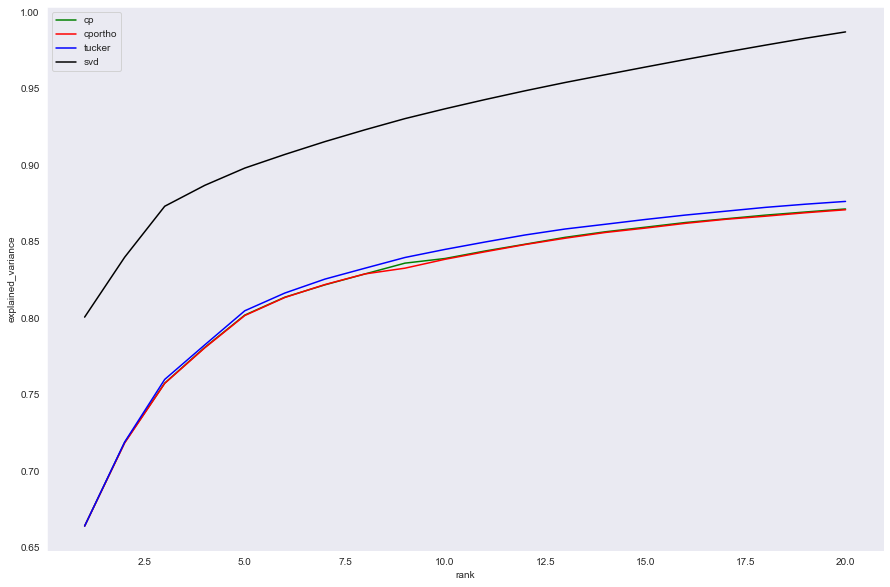

In [20]:
sns.lineplot( data = rank2var.cp, color='g', label='cp' )
sns.lineplot( data = rank2var.cportho, color='r', label='cportho')
sns.lineplot( data = rank2var.tucker, color='b', label='tucker')
ax = sns.lineplot( data = rank2var.svd, color='black', label='svd')
ax.set(xlabel='rank', ylabel='explained_variance')

[Text(0.5, 0, 'rank'), Text(0, 0.5, 'compute_time [seconds]')]

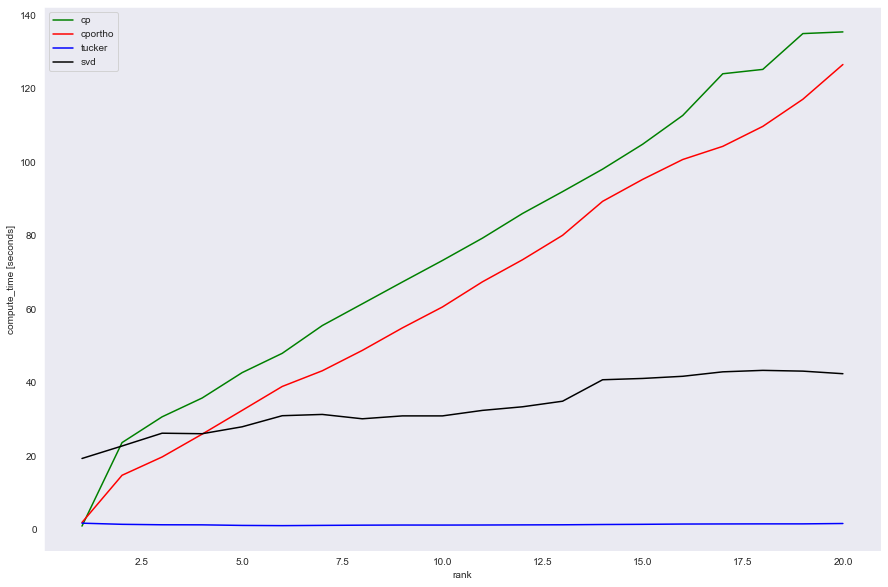

In [21]:
sns.lineplot( data = rank2took.cp, color='g', label='cp')
sns.lineplot( data = rank2took.cportho, color='r', label='cportho')
sns.lineplot( data = rank2took.tucker, color='b', label='tucker')
ax = sns.lineplot( data = rank2took.svd, color='black', label='svd')
ax.set(xlabel='rank', ylabel='compute_time [seconds]')

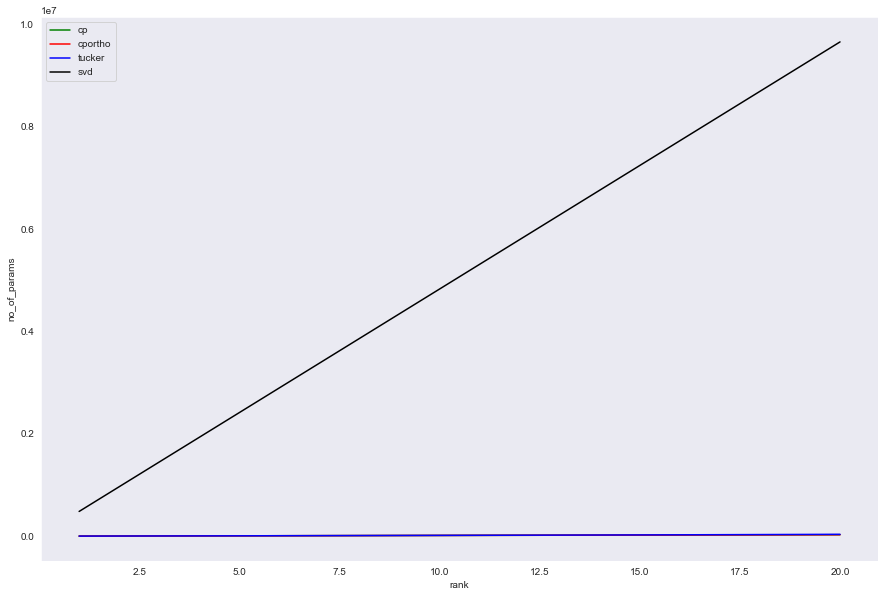

In [64]:
sns.lineplot( data = rank2nparams.cp, color='g', label='cp')
sns.lineplot( data = rank2nparams.cportho, color='r', label='cportho')
ax = sns.lineplot( data = rank2nparams.tucker, color='b', label='tucker')
#ax = sns.lineplot( data = rank2nparams.svd, color='black', label='svd')
ax.set(xlabel='rank',ylabel='no_of_params')
ax.legend()

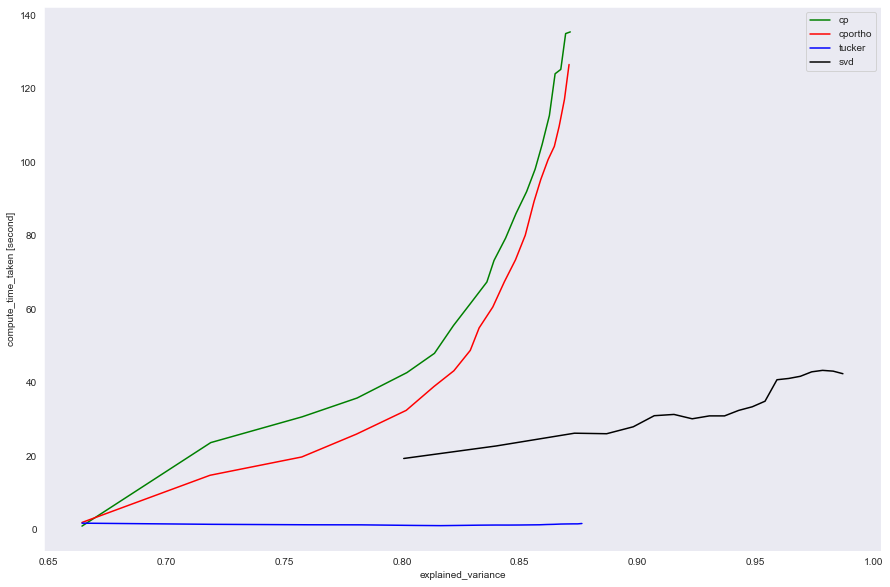

In [57]:
plt.plot(rank2var.cp, rank2took.cp, label='cp', c='g')
plt.plot(rank2var.cportho, rank2took.cportho, label='cportho', c='r')
plt.plot(rank2var.tucker, rank2took.tucker, label='tucker', c='b')
plt.plot(rank2var.svd, rank2took.svd, label='svd', c='black')
plt.xlabel('explained_variance')
plt.ylabel('compute_time_taken [second]')
plt.legend()

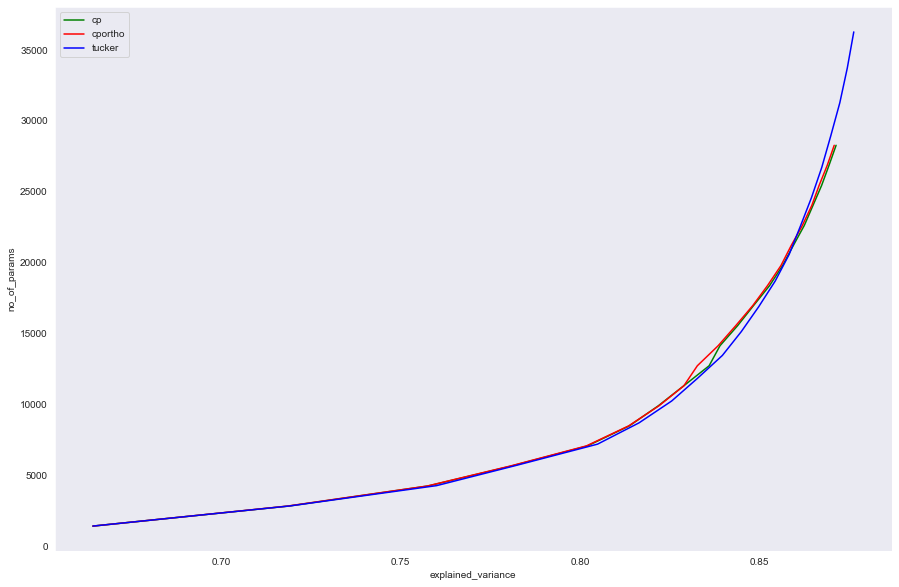

In [63]:
plt.plot(rank2var.cp, rank2nparams.cp, label='cp', c='g')
plt.plot(rank2var.cportho, rank2nparams.cportho, label='cportho', c='r')
plt.plot(rank2var.tucker, rank2nparams.tucker, label='tucker', c='b')
#plt.plot(rank2var.svd, rank2nparams.svd, label='svd', c='black')
plt.xlabel('explained_variance')
plt.ylabel('no_of_params')
plt.legend()

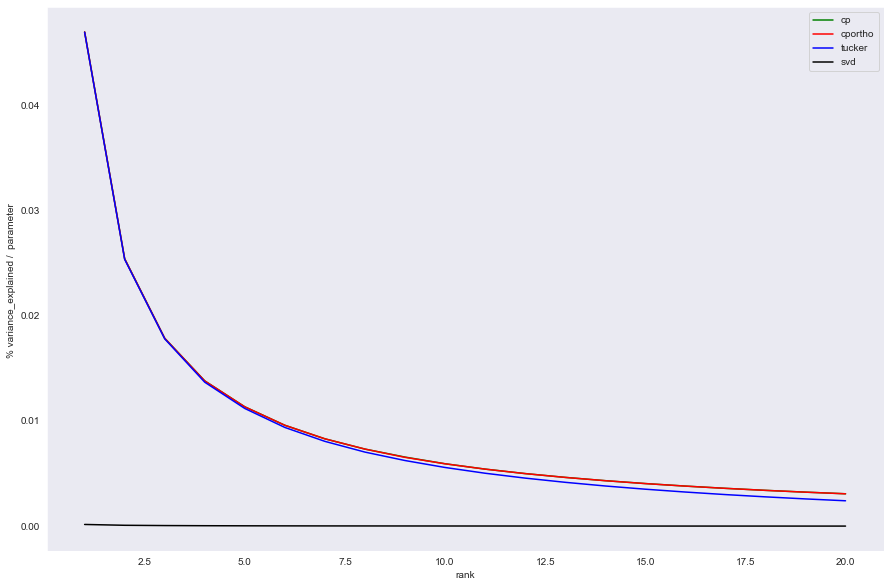

In [58]:
plt.plot(rank2var.cp *100 / rank2nparams.cp, label='cp', c='g')
plt.plot(rank2var.cportho *100/ rank2nparams.cportho, label='cportho', c='r')
plt.plot(rank2var.tucker *100/ rank2nparams.tucker, label='tucker', c='b')
plt.plot(rank2var.svd *100/ rank2nparams.svd, label='svd', c='black')
plt.xlabel('rank')
plt.ylabel('% variance_explained /  parameter ')
plt.legend()

In [35]:
np.array([1,2,3]) / np.array([1,2,6])

array([1. , 1. , 0.5])

In [54]:
rank2nparams.svd / rank2nparams.cp

1     341.378092
2     340.655853
3     339.458890
4     337.797203
5     335.684503
6     333.137931
7     330.177717
8     326.826793
9     323.110368
10    319.055482
11    314.690554
12    310.044929
13    305.148452
14    300.031056
15    294.722392
16    289.251497
17    283.646506
18    277.934407
19    272.140845
20    266.289967
dtype: float64

In [55]:
rank2nparams.svd / rank2nparams.tucker

1     341.378092
2     340.655853
3     339.458890
4     337.797203
5     335.684503
6     333.137931
7     330.177717
8     326.826793
9     323.110368
10    319.055482
11    314.690554
12    310.044929
13    305.148452
14    300.031056
15    294.722392
16    289.251497
17    283.646506
18    277.934407
19    272.140845
20    266.289967
dtype: float64

In [ ]:
### MORE RANK

In [78]:
explained_parafac2150 = [tensorrank2variance(k, 'parafac') for k in range(21,50)]


error -> 2926394.6845681746
parafac - rank-21 explained-> 0.8731744993364117
parafac - rank-21 took-> 145.21616458892822


error -> 2914806.422438809
parafac - rank-22 explained-> 0.8741769459572022
parafac - rank-22 took-> 162.6853687763214


error -> 2901762.184589724
parafac - rank-23 explained-> 0.875300583783723
parafac - rank-23 took-> 185.26398301124573


error -> 2883798.7861014404
parafac - rank-24 explained-> 0.8768397118783454
parafac - rank-24 took-> 193.70379781723022



MemoryError: Unable to allocate 1.70 TiB for an array with shape (483025, 483025) and data type float64

In [77]:
explained_tucker2150 = [tensorrank2variance(k, 'tucker') for k in range(21,50)]

c:\users\bzsnk3\miniconda3\lib\site-packages\tensorly\tucker_tensor.py:357: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


reconstruction error=0.34892144739377273, variation=4.3245607815933784e-05.
converged in 2 iterations.

error -> 2867195.272563284
tucker - rank-21 explained-> 0.8782538235486341
tucker - rank-21 took-> 1.6500694751739502

reconstruction error=0.3463578983699163, variation=6.780497208708214e-05.
converged in 2 iterations.

error -> 2846129.798666262
tucker - rank-22 explained-> 0.880036206236774
tucker - rank-22 took-> 1.6924989223480225

reconstruction error=0.34369269381636774, variation=3.5370884447938344e-05.
converged in 2 iterations.

error -> 2824228.9898927393
tucker - rank-23 explained-> 0.8818753322172486
tucker - rank-23 took-> 1.7842397689819336

reconstruction error=0.3412896949238713, variation=2.890330445265432e-05.
converged in 2 iterations.

error -> 2804482.80599949
tucker - rank-24 explained-> 0.8835213441387698
tucker - rank-24 took-> 2.4272124767303467



MemoryError: Unable to allocate 1.70 TiB for an array with shape (483025, 483025) and data type float64

In [ ]:
### MASK